# STARX - EMG Support Vector Machine:
The python script will calculate the most optimal Support Vector Machine (SVM) from EMG comma seperated value file. 


In [4]:
!pip install -U micromlgen
!pip install -U scikit-learn

import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
# Library to parse data and navigate folders
from glob import glob
from sklearn import model_selection
from os.path import basename
import csv
# Library for Normalisation of input data X
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
# Library for clearing output of cell
from IPython.display import clear_output
# Stop warning from Y being in list form instead of dp.
import warnings
from sklearn.exceptions import DataConversionWarning
# Library to convert sklearn model to c library file.
from micromlgen import port
# Graphing library to validate SVM.
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed
import seaborn as sns
# Libraries for Generating Classification Report and GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Global Variables:
debug = True

if debug == True:
  print(f"Numpy version = {np.__version__}\n")
  print(f"Pandas version = {pd.__version__}\n")
  print(f"Sklearn version = {sklearn.__version__}\n")
  print(f"MathPlotLib version = {matplotlib.__version__}\n")

Requirement already up-to-date: micromlgen in /usr/local/lib/python3.6/dist-packages (1.1.20)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.0)
Numpy version = 1.19.4

Pandas version = 1.1.5

Sklearn version = 0.24.0

MathPlotLib version = 3.2.2



In [5]:
# Authorise with a google account acceess to google drive.
# Copy and paste authorisation code to cell input.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## User input parameters

Defines what the directory for the data is, number of rows in .csv file classify a movement, normilsation scaler, seed and filename for output the program will use.

In [30]:
# User Input for the python file to refer to
# directory_data is directory where the data location is in the google drive.
directory_data = "/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile"
# Number of rows in .csv files that classify one movement
rows_classify_movement = 90
# What type of normalisation preprocessing do you want to do on X data before SVM calculations. (None, StandardScaler, Normalizer, MinMaxScaler)
normalisation_scaler = "MinMaxScaler"
# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook runs.
SEED = 222
# Directory and name of report for SVM to save to in google drive.
directory_output_svm = "/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVM/SVC_output4.txt"

## Upload Data

1. Open the panel on the left side of Colab by clicking on the __file__ button
1. Drag `____.csv` files from your computer to the tab to upload them to Google Colab.

Three parts of the leg muscle voltages we will be analysing will include Gastrocnemius (GM), Tibialis Anterior (TA) and Rectus Femoris (RF).

The format of the file should be set up as:

```
Voltage_1,Voltage2,Voltage3
0.232142,0.122421,0.212321
0.232142,0.122421,0.212321
0.838743,0.987373,0.735662
0.778921,0.827471,0.924827
0.837372,0.092882,0.028221
0.827472,0.827212,0.872476
```
The file should contain all the EMG values for that specific movement. The file name will be used as the label for that movement. Each 90 rows of the lines classifies one movement.

## Graph Input Data

Here you can graph the input file.

#### 2D Input Graph
Creates a graph with Sample Number on X axis and Voltage on Y axis.

Label values: 
[[ 65]
 [ 65]
 [ 68]
 ...
 [357]
 [378]
 [368]]


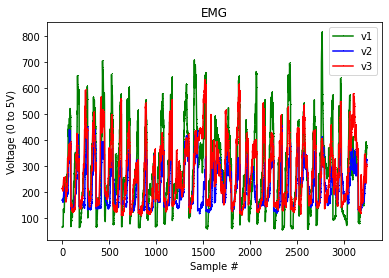

Label values: 
[[215]
 [209]
 [203]
 ...
 [125]
 [137]
 [140]]


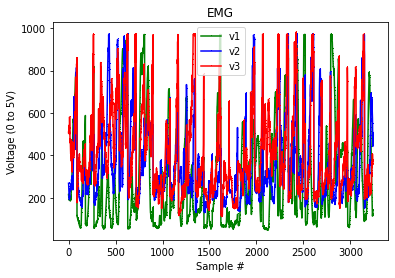

Label values: 
[[ 33]
 [ 33]
 [ 31]
 ...
 [626]
 [601]
 [574]]


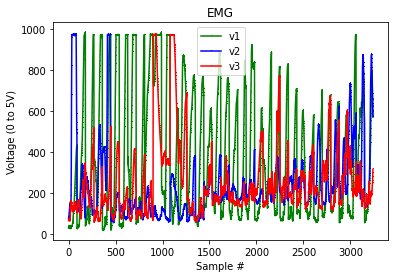

In [21]:
# Put filename into parameter to print input csv file.
# -param folder is string of directory where the data location is in the google drive
def input_graph(folder):
  for class_idx, filename in enumerate(glob('%s/*.csv' % folder)):
    # Read dataset into pandas dataframe.
    # Use pandas to read csv and split each column to corresponding column names.
    # Ignores first row, which is the column titles included for the dataset.
    df = pd.read_csv(filename, skiprows=1, names=["v1", "v2", "v3", "label"])

    # Generates index list from 0 to size of column v1.
    index = range(0, len(df['v1']))

    # Extract target values.
    Y = df.loc[:, ['v1']].values
    if debug == True:
      print("Label values: ")
      print(Y)

    plt.plot(index, df['v1'], 'g.', label='v1', linestyle='solid', marker=',')
    plt.plot(index, df['v2'], 'b.', label='v2', linestyle='solid', marker=',')
    plt.plot(index, df['v3'], 'r.', label='v3', linestyle='solid', marker=',')
    plt.title("EMG")
    plt.xlabel("Sample #")
    plt.ylabel("Voltage (0 to 5V)")
    plt.legend()
    plt.show()

# Put filename into parameter to print input csv file.
input_graph(directory_data)

## Train Support Vector Machine

### Parse data

The next cell parses X (Data) and Y (Label) values from the `.csv` file and transforms them into a format used to train the Support Vector Machine. 

In csv file: 
*   One movement is made up of SAMPLES_PER_FEATURE rows.
*   Cell below will put voltage1, voltage2, voltage3 into a list SAMPLES_PER_FEATURE times. Then that list will be stored in X list.
*   Cell bellow will collect every SAMPLES_PER_FEATURE item in Label column and store it into Y list.

In [31]:
# Parse the X (Data) and Y (Label) values from .csv file and transform into format for SVM.
# -param folder is string of directory where the data location is in the google drive.
# -param samples_per_feature is integer of how many rows classify a movement in .csv file.
# -return X list, Y list and classmap (a dictionary where the key is the class index, the value is the class name. For example {0: "leg_up", 1: "leg_down", 2: "leg_back",...})
def parse_data(folder, samples_per_feature):
  Y = []
  X = []
  Y = np.array(Y)
  classmap = {}
  for class_idx, filename in enumerate(glob('%s/*.csv' % folder)):
    if debug == True:
      print(filename)
    # Creates dictionary with key as label and value as title of csv files in folder
    class_name = basename(filename)[:-4]
    classmap[class_idx] = class_name
    df = pd.read_csv(filename, skiprows=1, names=["v1", "v2", "v3", "label"])
    num_features = len(classmap)
    # create a one-hot encoded matrix that is used in the output
    one_hot_encoded_features = np.eye(num_features)
    # calculate the number of feature recordings in the file
    num_recordings = int(df.shape[0] / samples_per_feature)
    for i in range(num_recordings):
      tensor = []
      for j in range(samples_per_feature):
        index = i * samples_per_feature + j
        tensor += [
            df["v1"][index],
            df["v2"][index],
            df["v3"][index]
        ]
      Y = np.append(Y, class_idx)
      X.append(tensor)
    # convert the X (Data) and Y (Label) lists into numpy array
  X = np.array(X)
  if debug == True:
    print("X")
    print(X)
    print(X.shape)
    print("Y")
    print(Y)
    print(Y.shape)
    print("classmap: ")
    print(classmap)
    print("Data set parsing and preparation complete.")
  return X, Y, classmap


X, Y, classmap = parse_data(directory_data, rows_classify_movement)

/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Heel_Up.csv
/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Leg_Down.csv
/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Leg_Up.csv
X
[[ 65 170 215 ... 449 386 378]
 [ 69 139 145 ... 590 294 296]
 [ 64 147 162 ... 554 449 435]
 ...
 [104 327 372 ... 971 591 353]
 [192 310 190 ... 550 530 143]
 [ 61 147 126 ... 574 571 317]]
(108, 270)
Y
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 

### Split Data into Training, Testing and Prediction:

In [32]:
# Ignore Sklearn model error with Y list parameter not being np array.
warnings.filterwarnings(action="ignore", category=DataConversionWarning)

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook runs.
np.random.seed(SEED)
random_number = np.random.randint(1000)

if (normalisation_scaler == "None"):
    pass
elif (normalisation_scaler == "StandardScaler"):
    # Normalise Dataset with standard scaler
    # Standardize features by removing the mean and scaling to unit variance
    normalisation_scaler = "StandardScaler"
    X = StandardScaler().fit_transform(X)
elif (normalisation_scaler == "Normalizer"):
    # Normalise Dataset with Normalizer
    # Normalize samples individually to unit norm.
    normalisation_scaler = "Normalizer"
    X = Normalizer().fit(X).transform(X)
elif (normalisation_scaler == "MinMaxScaler"):
    # Normalise Dataset with MinMaxScaler
    # Transform features by scaling each feature to a given range.
    normalisation_scaler = "MinMaxScaler"
    X = MinMaxScaler().fit(X).transform(X)
else:
    print("Error: Invalid preprosessing selected!")

# Keep 40% of csv data reserved for testing purpose and 60% data will be used to train and formulate the SVM model.
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.4, random_state=random_number)

### Build, Train and Test Support Vector Machine Model

Build, train and learn a [Sklearn](https://scikit-learn.org/stable/modules/svm.html) model using the python [micromlgen](https://github.com/eloquentarduino/micromlgen) library.

#### Building SVC (Support Vector Classification)

Generates `.csv` file containing all combinations of parameters and tests for highest value of each category found in scores list.

To download `SVC_output.txt`:
1. Navigate to filepath specified in input on google drive.
1. Download file from google drive.

In [ ]:
# Parameters
C = [0.001,0.01,0.1,1,10,100,1000,10000]   # Default 1.0
kernel = ['linear','poly','rbf','sigmoid']    # Default rbf
degree = [1,2,3,4,5,6,7,8,9,10,11,12]    # Default 3
# Gamma should not go above or include 1
gamma = [0.00001,0.001,0.1,'scale', 'auto']    # Default=scale
coef0 = [0,1,2,3,4,5,6,7,8,9,10,11,12]   # default = 0.0
shrinking = [True]   # Default True
probability = [True,False]    # default=False
tol = [0.001]
# For arduino due there is 96 KBytes (two banks: 64KB and 32KB) of SRAM and 512 KBytes of flash memory for code.
# Max size of library will be 0.3Mb or 300KBytes
memory_allocated = [0.3]
decision_function_shape = ['ovo','ovr']    # default=’ovr’
total_grid_scores_displayed = 120

# Set the parameters by cross-validation
# Poly kernel should never has gamma as parameter, this will break most metrics cases being tested.
tuned_parameters = [{"kernel": ["poly"], "C": C, "degree": degree,
                     "coef0": coef0, "shrinking": shrinking, "probability": probability,
                     "tol": tol, "cache_size": memory_allocated, "decision_function_shape": decision_function_shape},
                    {"kernel": ["linear"], "C": C, "shrinking": shrinking, "probability": probability,
                     "tol": tol, "cache_size": memory_allocated, "decision_function_shape": decision_function_shape},
                    {"kernel": ["rbf"], "C": C, "gamma": gamma, "shrinking": shrinking, "probability": probability,
                     "tol": tol, "cache_size": memory_allocated, "decision_function_shape": decision_function_shape},
                    {"kernel": ["sigmoid"], "C": C, "gamma": gamma, "coef0": coef0, "shrinking": shrinking, "probability": probability,
                     "tol": tol, "cache_size": memory_allocated, "decision_function_shape": decision_function_shape}]

# Type sorted(sklearn.metrics.SCORERS.keys()) to find all avaliable scores for current version of sklearn.
scores = ["accuracy", "precision_micro", "recall_micro", "r2", "neg_root_mean_squared_error"]

# Generates content for report in google drive folder
counter = 0
with open(directory_output_svm, 'w') as f:
  for score in scores:
      print("Randomisation Seed: %s." % SEED)
      print("Normalisation Scaler for Input: %s." % normalisation_scaler)
      print("# Tuning hyper-parameters for %s" % score, file=f)
      print("\n", file=f)

      clf = model_selection.GridSearchCV(
          svm.SVC(), tuned_parameters, scoring='%s' % score, verbose=1
      )
      clf.fit(X_train, Y_train)

      print("Best parameters set found on development set:", file=f)
      print("\n", file=f)
      print(clf.best_params_, file=f)
      print("\n", file=f)
      print("Grid scores on development set:", file=f)
      print("\n", file=f)
      means = clf.cv_results_['mean_test_score']
      stds = clf.cv_results_['std_test_score']
      zipped_sorted = sorted(zip(means, stds, clf.cv_results_['params']), key = lambda x: x[0], reverse=True)
      # Creates a zip list of mean, standard deviation and results in largest to smallest order of mean.
      for mean, std, params in zipped_sorted:
        if (counter <= total_grid_scores_displayed):
          counter += 1
          print("%0.4f (+/-%0.04f) for %r" % (mean, std * 2, params), file=f)
        else:
          counter = 0
          break
      print("\n", file=f)

      print("Detailed classification report:", file=f)
      print("\n", file=f)
      print("The model is trained on the full development set.", file=f)
      print("The scores are computed on the full evaluation set.", file=f)
      print("\n", file=f)
      Y_true, Y_pred = Y_test, clf.predict(X_test)
      print(classification_report(Y_true, Y_pred, target_names=classmap.values()), file=f)
      print("\n", file=f)

## Verify 

Graph selected model on its performance vs validation. You can verify accuracy and K Fold Cross Validation of the most optimal models that was collected from files.


In [26]:
# Verify Sklearn Model selected by user with different metrics
# -param model is sklearn model
# -return float value for mean_accuracy, precision, recall, r2, root_mean_square_error
def verify_svm(model):
    # Root mean square error: The  root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. 
    # It measures the standard deviation4 of the errors the system makes in its predictions. Lower vaules indicate a better fit. 

    # Precision: The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

    # Recall: The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.

    # R^2 (coefficient of determination) regression score function. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

    scores = model_selection.cross_validate(model, X, Y, cv=3,
                            scoring=('precision_macro', 'recall_macro', 'r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    root_mean_square_error = -1*scores['test_neg_root_mean_squared_error'].mean()
    precision = scores['test_precision_macro'].mean()
    recall = scores['test_recall_macro'].mean()
    r2 = scores['train_r2'].mean()

    # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
    # Return the mean accuracy on the given test data and labels.
    mean_accuracy = model.score(X_test, Y_test)
    return mean_accuracy, precision, recall, r2, root_mean_square_error

## User Input:
model = svm.SVC(C=0.1, kernel='linear', degree=6, gamma=0.1, coef0=1, shrinking=False, cache_size=0.3, decision_function_shape='ovr').fit(X_train, Y_train)
verify_svm(model)

(0.25,
 0.8020569678636412,
 0.6944444444444443,
 0.14583333333333334,
 0.7941880564652282)

### Graph the Decision Boundaries

Comparison of different Support Vectors on a 2D projection. We only consider the first 2 features of this dataset:

*   Voltage 1
*   Voltage 2



#### 2D Support Vector Machine Decision Boundary Graph

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


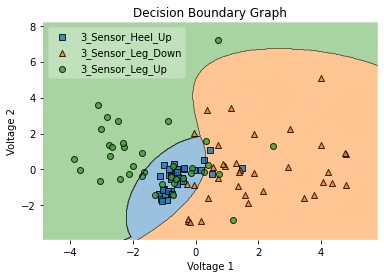

{0: '3_Sensor_Heel_Up', 1: '3_Sensor_Leg_Down', 2: '3_Sensor_Leg_Up'}


In [33]:
# Plot 2d decision boundary graph of sklearn graph
# -param X: features matrix
# -param Y: labels vector
# -param classmap: a dictionary where the key is the class index, the value is the class name. For example {0: "leg_up", 1: "leg_down", 2: "leg_back",...}
def plot_2d_decision_boundaries(model, X, Y):
    """
    model: an untrained model
    X: features matrix
    Y: labels vector
    classmap: a dict where the key is the class index, the value is the class name. 
              For example {0: "setosa", 1: "versicolor", 2: "virginica"}
    """
    labels = None
    # project X into 2d
    X = PCA(n_components=2).fit_transform(X)
    ax = plot_decision_regions(X, Y.astype(np.uint8),
                          clf=model.fit(X, Y),
                          legend=1,)
    # Label Legend, Title and Axies
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, 
            classmap.values(), 
            framealpha=0.3, scatterpoints=1)
    plt.xlabel('Voltage 1')
    plt.ylabel('Voltage 2')
    plt.title("Decision Boundary Graph")
    plt.show()

# Calculations for gamma scale and auto
gamma_scale = (1/(108 * X.var()))
gama_auto = 1/X.var()

## User input:

model = svm.SVC(C=0.001,cache_size=0.3,coef0=10,decision_function_shape='ovo',degree=4,kernel='poly',probability=True,shrinking=True,tol=0.001).fit(X_train, Y_train)

plot_2d_decision_boundaries(model, X, Y)
print(classmap)

#### 3D Support Vector Machine Decision Boundary Graph

#### Confusion Matrix Heat Map

This helps us get a sense of which labels are likely to be confused by the estimator. The lower the score the better the estimator.

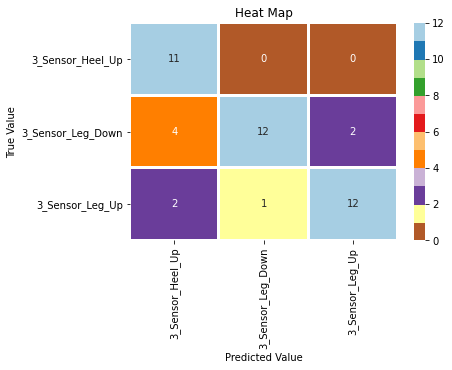

In [34]:
# Plot 2d decision boundary graph of sklearn graph
# -param X: features matrix
# -param Y: labels vector
# -param classmap: a dictionary where the key is the class index, the value is the class name. For example {0: "leg_up", 1: "leg_down", 2: "leg_back",...}
def plot_2d_heat_map(model, X_test):
    Y_true, Y_pred = Y_test, model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    sns.heatmap(cm, annot=True, cmap="Paired_r", linewidth=2, linecolor='w', fmt='.0f', xticklabels=classmap.values(), yticklabels=classmap.values())
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.title("Heat Map")
    plt.show()

## User Input:
# Calculations for gamma scale and auto
gamma_scale = (1/(108 * X.var()))
gama_auto = 1/X.var()
# Model to analyse
model = svm.SVC(C=0.001,cache_size=0.3,coef0=10,decision_function_shape='ovo',degree=4,kernel='poly',probability=True,shrinking=True,tol=0.001).fit(X_train, Y_train)
# Display heatmap
plot_2d_heat_map(model, X_test)

### Predict classifier for user defined input
Predict the Target with a given input parameter

In [ ]:
# Enter a input that you would find in X (Data) at the size of SAMPLES_PER_FEATURES *  FEATURES (3 being v1, v2, v3)
data_for_prediction = []

# Model you want to test.
clf_ob = svm.SVC(kernel='linear', C=1, gamma=0.001).fit(X_train, Y_train)

# Calculate predicted classifier for given data_for_prediction defined by user.
# predict can handle multiple parameters from data_for_prediction
p_res = clf_ob.predict(data_for_prediction[0])
p_prob_res = clf_ob.predict_proba(data_for_prediction[0])
p_log_prob_res = clf_ob.predict_log_proba(data_for_prediction[0])
print("Predicted Target: ", p_res[0])
print("Predicted Probability Target: ", p_prob_res[0])
print("Predicted Log Probability Target: ", p_log_prob_res[0])

IndexError: ignored

## Export Python to C Library

Now you can convert the SVM trained classifier to plain C code using the micromlgen package. Copy output of cell below into a library file. Place the library file you created into arduino script enviroment.

In [ ]:
# Select highest average score and fill line below.
gamma_scale = (1/(108 * X.var()))
svc1 = svm.SVC(C=0.001,cache_size=0.3,coef0=3,decision_function_shape='ovr',gamma=gamma_scale,degree=6,kernel='poly',probability=False,shrinking=True,tol=0.001).fit(X_train, Y_train)
# Convert trained classifier to C code.
c_code = port(svc1, classmap=classmap)
print(c_code)